In [1]:
from typing import Dict, List, Union

import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

%matplotlib inline
import matplotlib.pylab as pylab
import matplotlib as mpl

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, StratifiedKFold

from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

from keras.metrics import (TruePositives, FalsePositives, TrueNegatives, FalseNegatives, 
                           BinaryAccuracy, Precision, Recall, AUC)

Using TensorFlow backend.


In [4]:
pylab.rcParams['figure.figsize'] = 10, 10
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Summary

**First thoughts**

The task is to classify the bounding box from the input invoice to a text item or not. 

Each invoice has several bounding boxes of different sizes. Also, an invoice can contain more than one page.

Available data:
- length of the bounding box value
- relative location of the bounding box
- a sequence of bounding boxes per invoice

I would expect the text items: 
- are located on the left side of the page
- are located somewhere between below the headers and the bottom of the first page, but on the 2nd page they are located all over the page
- have a bigger bounding box than e.g. raw values; since items are more specified than e.g. the price
- that there is a sequence of bounding boxes on the same y-coordinates with [item, no item, no item], and so on. Indicating, the text and then the price, taxes, and so on.

This is only true for most german invoices. My experience lacks international invoices, but I assume, it will be the same for most of the countries using a Latin alphabet. 

**Steps**:

The data is imbalanced. Every invoice has at least one text item, but only 5% of the provided bounding boxes are text items (ignoring the invoice id structure). The chosen metric for the classification is the F1-Score, which is calculated by precision and recall.

I followed two approaches:

- Train a tree & ensemble on the data. I try to add the sequence of bounding boxes for each id to get more information. This is also my fallback solution, if I fail with my other approach. Also, I will see, how good a text classification can be generalized by the position on a page. Here I also tried over- and undersampling of the data. Oversampling costs too much time in training and doesn't give any benefit in the F1-score. I discarded this approach.
Under-sampling works well with a comparable good F1-Score. The prediction on the whole training dataset will still result in a low F1-Score. I assume, the data is noisy and there need some additional steps found before the bbox classificition.

- Training an LSTM, which takes the sequence of the bounding boxes into considerations. For me, it was unclear, if I can get to a running model and if, how well will it perform. Also, the training of my last LSTM is a while ago and for my current project of implementing deep learning models from scratch, LSTMs will be done next week. So I'm currently renewing my expertise. Also I introduce weights based on the amount of the labels in the data. My approach here has many short-comings, but in my overnight training, I got a model, which outperforms the XGBoost model. So I tried to add the code here, but there is somewhere an error.

**Results** on the test set are:

XGBoost:
- F1: 0.30
- Precision: 0.20
- Recall: 0.61

LSTM:
- F1: 0.53
- Precision: 0.47
- Recall: 0.59

The precision is in both models bad. There are too many False Positives, non-text items classified as text-items. 
One reason is, that the data is "noisy", as seen in the pair plots. The recall is good, but there are too many False Positives in the prediction, which means, there had to be much more cleaning in the end. Adding the previous and following bbox to a prediction give a small boost in the F1-Score. But in the end, it is still not good enough.

**Future steps** to improve the models is:

- feature engineering - I didn't spend much time here, but just counting elements in specific areas could be an improvement. One goal could be to get a classification of the type of invoice itself.. 

- invoice classification - there are different types of invoices, probably

- thinking in calm about the problem. It still can be, that I missed something very obvious. probably I messed up at feature engineering or data preparation. There are a lot more possibilities beyond the applied bbox volume.

- doing research; I'm definitely not the first, who works on this kind of sequential problem. There should be some papers, just to collect more ideas.

- model improvement: the LSTM needs definitely more time; probably longer sequences, more features. Since this is a very very early prototype, I'm surprised that the model won't predict only zeros (as most of my prototypes did). 

1) What is good measure for classification accuracy? 

- imbalanced data; F1-Score, PR-AUC.
I will go for the  F1-Score, since a high precision or a high recall is not useful here, they just will end up in more manual work (cleaning) . The precision-recall curve can also be used for imbalanced data, therefor the PR-AUC can be a useful metric.

2) What are possible shortcomings and extensions of your implementation? 


- no proper cross-validation for the xgboost with hyperparameter search. Needs definetly a fix. I focused too much an model preparation for imbalanced data (under- and oversampling), prototyping different models than doing one thing right.
- A shortcoming is the low F1-score
- I need to find a more suitable model to represent the data structure for each invoice. I guessed an LSTM/RNN will handle this kind of data, but my prototype wasn't convincing. Probably some simpler models can help as a first step. For a tree approach, there should be more time spent in feature engineering, but my intuition says, that trees won't help with this structure. My LSTM is one whole shortcoming. It needs improvement in model architecture, data preparation (features and sequences), initialization, and so on.

- the values could give probably more information; e.g. if the item is a text or a number / nlp

- next step would be to revisit all my findings and my approaches. I put too much effort in different approaches than to think very deep about the problem. Normally the interesting ideas come, when the low-hanging fruits fail. :)


3) How would you design a real-time performance system that responds to a high volume of prediction requests efficiently.  

- I always deployed my models via flask, gunicorn, docker on k8s. This is normally scalable, but it always depends on the traffic volume. The model itself: I prefer small models with fewer preparation steps and a fast prediction. This normally hurts accuracy. For my examples, none of the models is production-ready by the metrics. If prediction time is the constraint, I would go for the XGboost.

### Data pipeline

Basically I take the json files and convert it into a csv file. 

I merge words and entitites by invoice id, page number and indices.

data is not cleaned.

The available raw data is split in words and entities. 
The words data includes the OCR detection of the text value and the according location of the bounding box on the page.
The entities data specifies the value of the words data. So it keeps the information, if the bounding box is an item or not. 

The helpers function is my repo

In [ ]:
import helpers

In [ ]:
files = ["hypatos-ds-train", "hypatos-ds-test"]

In [ ]:
#todo: get rid of the hard-coded column names; introduce a config file 
for file in files:
    helpers.data_preparation_strategy(file)

### Cleaning and preparation

In [78]:
class Transformer(object):

    def __init__(self, strategy):

        self.strategy = strategy

    def fit_transform(self, data):

        for transform in self.strategy:
            data = transform(data)

        return data

In [79]:
def drop_columns(data: pd.DataFrame) -> pd.DataFrame:
    return data.drop(["metaData.region.page", "n_idx_item"], axis=1)


def fill_nan(data: pd.DataFrame) -> pd.DataFrame:
    return data.fillna(0)


def encode_label(data):
    
    data["label"] = data["label"].replace("item", 1)
    
    return data

In [80]:
def remove_pages_with_no_text(data):

    items_per_page_id = data.groupby(["id", "region.page"])["label"].sum().reset_index()
    remove_from_training = items_per_page_id[items_per_page_id.label == 0]

    remove_idx = []

    for _, row in remove_from_training.iterrows():
        remove_idx.extend(data[(data["id"] == row["id"]) & (data["region.page"] == row["region.page"])].index)

    data = data[~data.index.isin(remove_idx)]
    
    del [items_per_page_id, remove_from_training, remove_idx]

    return data

In [81]:
def preprocessing(data, only_train=False):
    
    preprocessting_strategy = [drop_columns,
                                 fill_nan,
                                 encode_label,
                                ]

    feature_creator = Transformer(preprocessting_strategy)
    data = feature_creator.fit_transform(data)
    
    if only_train:
        
        data_cleaning_strategy = [remove_pages_with_no_text]
        data_cleaner = Transformer(data_cleaning_strategy)
        data = data_cleaner.fit_transform(data)

    return data

In [82]:
train = pd.read_csv("hypatos-ds-train.csv")
test = pd.read_csv("hypatos-ds-test.csv")

In [83]:
train = preprocessing(train, True)
test = preprocessing(test)

the label feature has two value, item and None. So this will be our classifier.


The metaData.region.page is identical with the region page, so it can also be dropped.
The n_idx_item is information I extracted from the entities data and counts the number of words in one entity dict. We won't have this information for the model training, so it also can be dropped.

## EDA

We have around 6 million bounding boxes from 24000 invoices with around 290000 text items. Around 5 % of the data is a text item. This is very inbalanced. 

In [84]:
train.shape

(4717803, 9)

In [85]:
train

,value,region.left,region.top,region.width,region.height,region.page,id,indices,label
0,U1Raiug=,0.371253,0.020022,0.025749,0.015017,1,83132716,0,0
1,WC8whnZ1fnk=,0.345503,0.033092,0.224058,0.028087,1,83132716,1,0
2,Lg==,0.345503,0.050334,0.039201,0.017798,1,83132716,2,0
3,d354fYR1ew==,0.406995,0.062291,0.048040,0.005840,1,83132716,3,0
4,Vw==,0.463874,0.062291,0.007302,0.005562,1,83132716,4,0
...,...,...,...,...,...,...,...,...,...
5991774,YWhmZA==,0.457143,0.965558,0.023529,0.004751,1,510220123,265,0
5991775,YmZraQ==,0.484034,0.965558,0.021849,0.004751,1,510220123,266,0
5991776,YWRf,0.509244,0.965558,0.015126,0.004751,1,510220123,267,0
5991777,c3t2,0.526050,0.965558,0.015126,0.004751,1,510220123,268,0


In [86]:
train.label.value_counts()

0    4429136
1     288667
Name: label, dtype: int64

In [87]:
100*288667/train.shape[0]

6.118674306663504

Every document has at least one text item. Also 1 % of the documents, has more then 100 items. This is possible, since some documents have several pages. But in case of an error, I would check with against the real data. It still could be, that the OCR system had some issues.

In [88]:
train["region.page"].value_counts()

1    4339214
2     284231
3      66627
4      20233
5       4550
6       1651
7        882
8        415
Name: region.page, dtype: int64

In [89]:
items_per_id = train.groupby(["id"])["label"].sum().reset_index()

In [90]:
items_per_id['label'].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.8, 0.9, 0.95, 0.99])

count    24073.000000
mean        11.991318
std         22.140643
min          1.000000
1%           1.000000
5%           1.000000
10%          2.000000
20%          3.000000
50%          6.000000
80%         15.000000
90%         24.000000
95%         39.000000
99%        102.000000
max        692.000000
Name: label, dtype: float64

In [91]:
items_per_page_id = train.groupby(["id", "region.page"])["label"].sum().reset_index()

In [92]:
items_per_page_id['label'].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.8, 0.9, 0.95, 0.99])

count    25409.000000
mean        11.360817
std         16.231832
min          1.000000
1%           1.000000
5%           1.000000
10%          2.000000
20%          3.000000
50%          6.000000
80%         15.000000
90%         25.000000
95%         39.000000
99%         82.000000
max        316.000000
Name: label, dtype: float64

In [93]:
items_per_page_id["region.page"].value_counts()

1    23457
2     1473
3      320
4      110
5       28
6       11
7        7
8        3
Name: region.page, dtype: int64

Also from the invoices, there are around 20 % of the pages without any text item. This is important information, since I wouldn't have expect such a high amount of non-text item pages. I will remove it to speed up training. This pages don't contain any information and probably will add only noise to the training.

In [94]:
train.label.value_counts()

0    4429136
1     288667
Name: label, dtype: int64

In [95]:
100*288667/train.shape[0]

6.118674306663504

Text(0.5, 1.0, 'Class Distributions \n (0: no text item || 1: text item)')

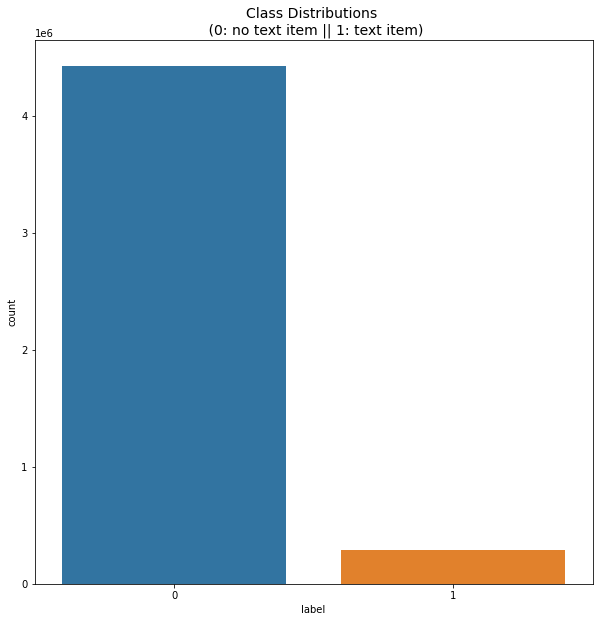

In [96]:
sns.countplot('label', data=train)
plt.title('Class Distributions \n (0: no text item || 1: text item)', fontsize=14)

In [97]:
train[train.label==0].describe(include="all", percentiles=[0.01, 0.05, 0.1, 0.2, 0.8, 0.9, 0.95, 0.99])

,value,region.left,region.top,region.width,region.height,region.page,id,indices,label
count,4429136,4.429136e+06,4.429136e+06,4.429136e+06,4.429136e+06,4.429136e+06,4.429136e+06,4.429136e+06,4429136.0
unique,501438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,3Q==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,64106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,4.469610e-01,5.419293e-01,4.525161e-02,7.777829e-03,1.103981e+00,2.715374e+08,1.357077e+02,0.0
std,NaN,2.594692e-01,2.786358e-01,3.872087e-02,3.223811e-03,4.152080e-01,1.254780e+08,1.403100e+02,0.0
min,NaN,-4.151261e-01,-4.274673e+00,0.000000e+00,-4.156770e-02,1.000000e+00,7.143602e+07,0.000000e+00,0.0
1%,NaN,4.923135e-02,5.085714e-02,2.001601e-03,1.141227e-03,1.000000e+00,7.460892e+07,1.000000e+00,0.0
5%,NaN,9.411765e-02,1.212034e-01,6.449012e-03,4.750594e-03,1.000000e+00,8.778061e+07,9.000000e+00,0.0
10%,NaN,1.176471e-01,1.701510e-01,1.008403e-02,5.050505e-03,1.000000e+00,1.086045e+08,1.800000e+01,0.0


In [98]:
train[train.label==1].describe(include="all", percentiles=[0.01, 0.05, 0.1, 0.2, 0.8, 0.9, 0.95, 0.99])

,value,region.left,region.top,region.width,region.height,region.page,id,indices,label
count,288667,288667.000000,288667.000000,288667.000000,288667.000000,288667.000000,2.886670e+05,288667.000000,288667.0
unique,68353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Xg==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,6712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.297313,0.508321,0.049002,0.008029,1.181140,2.753828e+08,156.595686,1.0
std,NaN,0.137272,0.132797,0.035979,0.001990,0.520034,1.243393e+08,162.404479,0.0
min,NaN,0.001681,0.020202,0.000000,0.000000,1.000000,7.143602e+07,0.000000,1.0
1%,NaN,0.061766,0.164655,0.003361,0.001188,1.000000,7.508456e+07,22.000000,1.0
5%,NaN,0.100403,0.305162,0.006723,0.004985,1.000000,8.850620e+07,40.000000,1.0
10%,NaN,0.127731,0.359857,0.010676,0.005945,1.000000,1.136816e+08,50.000000,1.0


### Feature engineering

In [99]:
def calculate_bbox_volumn(data: pd.DataFrame) -> pd.DataFrame:
    
    data["bbox_volumn"] = abs(data['region.width'] * data['region.height'])
    
    return data


def calculate_value_length(data: pd.DataFrame) -> pd.DataFrame:
    
    data["value_length"] = [len(i) for i in data["value"]]
    
    return data


def drop_unrelated_columns(data: pd.DataFrame) -> pd.DataFrame:
    return data.drop(["value", "id", "indices"], axis=1)

In [100]:
def add_bbox_sequence(data: pd.DataFrame) -> pd.DataFrame:
    
    colnames = ['region.left', 'region.top', 'region.width', 'region.height', 'region.page']
    
    base = data.copy()
    
    for i in range(-2,3):
        if i == 0:
            continue
    
        shift_data = base.groupby(['id'])['region.left', 'region.top', 'region.width', 'region.height', 'region.page'].shift(i)
        new_col = [col + f"_shifted_{i}" for col in colnames]

        shift_data.columns = new_col

        data = pd.concat([shift_data, data], axis=1)
        
    
    del [base, shift_data]

    return data

In [101]:
def feature_engineering(data):
    
    feature_engineering_strategy = [calculate_bbox_volumn,
                                    calculate_value_length,
                                    add_bbox_sequence,
                                    fill_nan,
                                    drop_unrelated_columns
                                    ]

    feature_creator = Transformer(feature_engineering_strategy)
    data = feature_creator.fit_transform(data)
    
    return data

In [102]:
train.columns

Index(['value', 'region.left', 'region.top', 'region.width', 'region.height',
       'region.page', 'id', 'indices', 'label'],
      dtype='object')

In [103]:
train = feature_engineering(train)
test = feature_engineering(test)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


Also it is bad practice, but I prefer to undersample, before I create plots. From the desciptive analysis, there is a hugh overlap between non-text items and text items. This will become more clear with plots.

## Imbalanced Data

There are several methods to deal with imbalanced data. As a common practice, there is

- oversampling (random, SMOTE)
- undersampling (random, clustering)


Since training time over night is free, I played around with over- and undersampling. From my experience, undersampling was faster and provided a higher F1-scores. Overall the performance is not great, but with undersampling, I got better results. So I will continue here.

A problem with random undersampling is, that probably some important data points for the classification will be missing. Also removing data is most of the time not a good strategy.

In [104]:
def create_sub_sample(data, factor=1, seed=12345):
    
    text_items = data[data["label"] == 1]
    non_text_items = data[data["label"] == 0]

    idx = np.random.choice(non_text_items.index, size=factor*text_items.shape[0], replace=True, p=None)
    
    sub_sample_non_text_items = non_text_items.loc[idx]
    
    assert sub_sample_non_text_items.shape[0] == text_items.shape[0] * factor
    
    sub_sample = pd.concat([text_items, sub_sample_non_text_items], axis=0)
    sub_sample.reset_index(inplace=True, drop=True)
    
    del [text_items, non_text_items, idx, sub_sample_non_text_items]

    return sub_sample

In [105]:
sub_train = create_sub_sample(train, 2)

Text(0.5, 1.0, 'Class Distributions \n (0: no text item || 1: text item)')

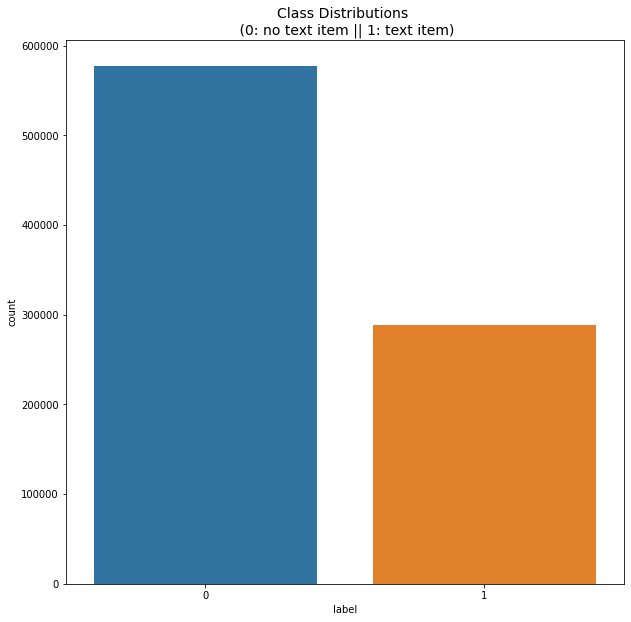

In [106]:
sns.countplot('label', data=sub_train)
plt.title('Class Distributions \n (0: no text item || 1: text item)', fontsize=14)

Plotting with undersampled data is not good, but based on calculation time, I will have a look. Some information for the non-text label will be missing.

In [107]:
train.columns

Index(['region.left_shifted_2', 'region.top_shifted_2',
       'region.width_shifted_2', 'region.height_shifted_2',
       'region.page_shifted_2', 'region.left_shifted_1',
       'region.top_shifted_1', 'region.width_shifted_1',
       'region.height_shifted_1', 'region.page_shifted_1',
       'region.left_shifted_-1', 'region.top_shifted_-1',
       'region.width_shifted_-1', 'region.height_shifted_-1',
       'region.page_shifted_-1', 'region.left_shifted_-2',
       'region.top_shifted_-2', 'region.width_shifted_-2',
       'region.height_shifted_-2', 'region.page_shifted_-2', 'region.left',
       'region.top', 'region.width', 'region.height', 'region.page', 'label',
       'bbox_volumn', 'value_length'],
      dtype='object')

In [108]:
dist_data = pd.melt(sub_train[['region.left', 'region.top', 'region.width', 'region.height', 'label', 'bbox_volumn']], 
                              id_vars=["label"])

In the pairplot is it very obvious, that the non-text items overlie the text items. Other way, the text items are found only on a specific part of the page. Mostly in the relative top-left of a page. The width and the height of the bbox doesn't show a big difference, as in the box plots below.

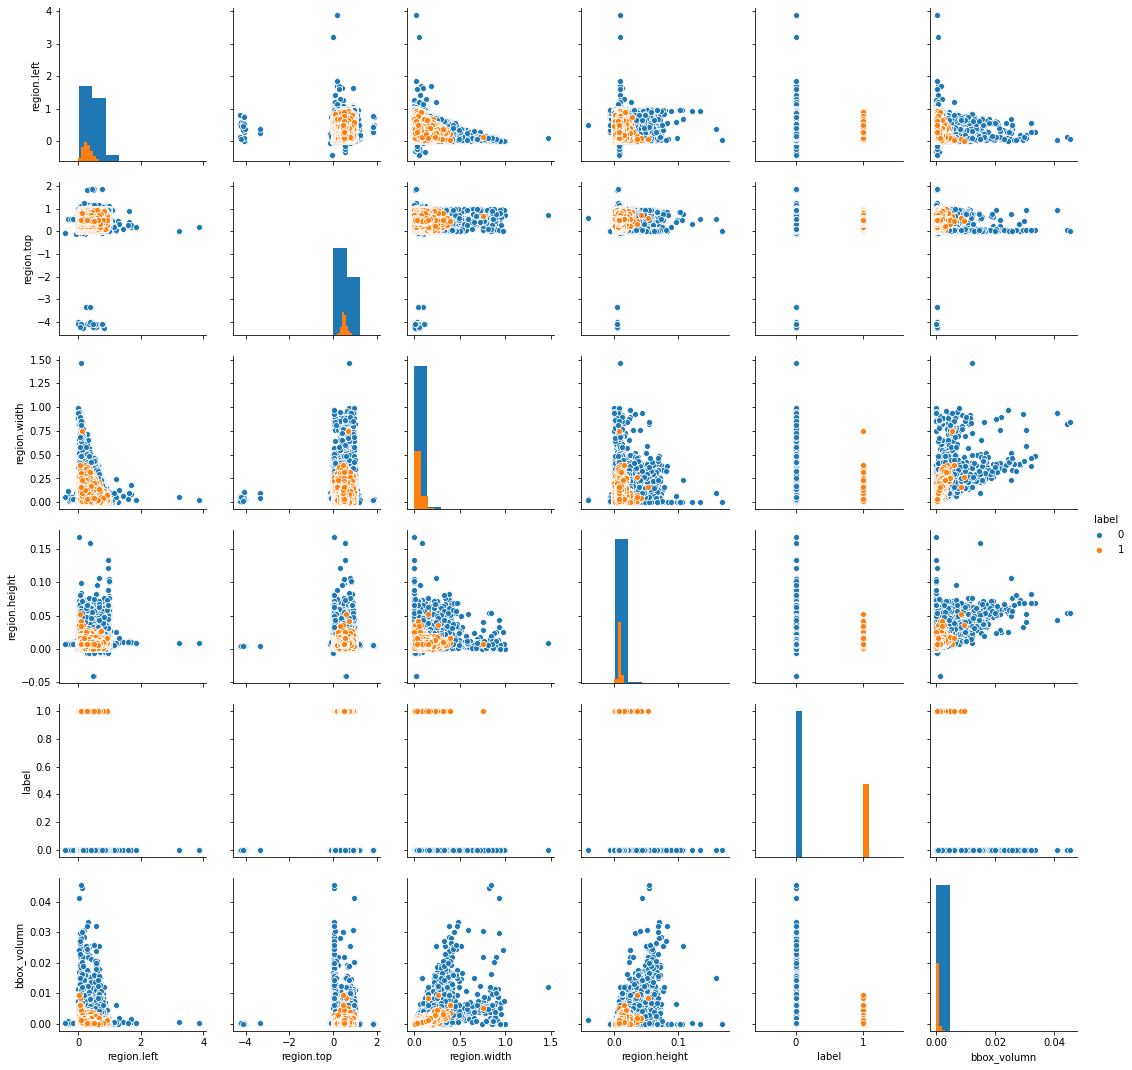

In [109]:
sns.pairplot(sub_train[['region.left', 'region.top', 'region.width', 'region.height', 'label', 'bbox_volumn']], height = 2.5, diag_kind='hist', hue="label")
plt.show()

plot doesn't work; needs refactoring

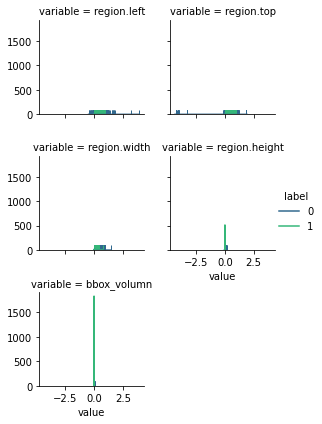

In [110]:
g = sns.FacetGrid(dist_data, col='variable', hue="label", palette="viridis", height=2, col_wrap=2)
g = (g.map(sns.distplot, "value", hist=False, rug=True, bins=50, hist_kws={'alpha': 0.5}).add_legend())

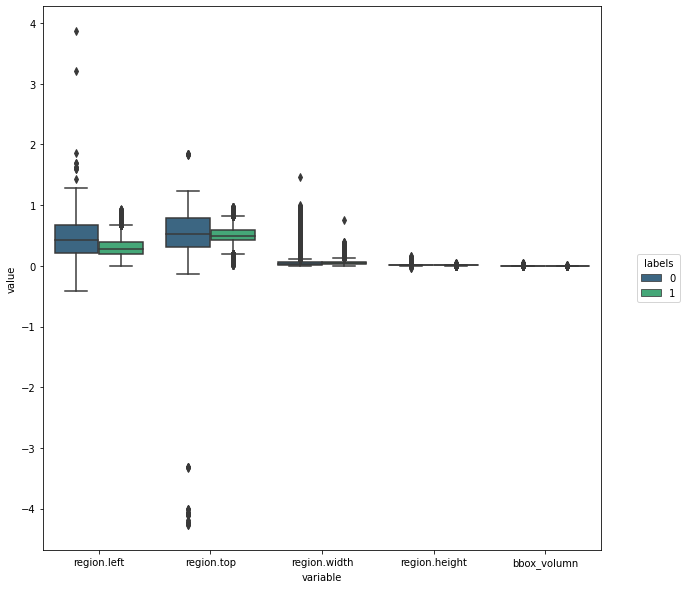

In [111]:
sns.boxplot(x="variable", y="value", hue='label', palette="viridis",
            data=dist_data)

plt.legend(title="labels", loc='center right', bbox_to_anchor=(1.15, 0.5), ncol=1)

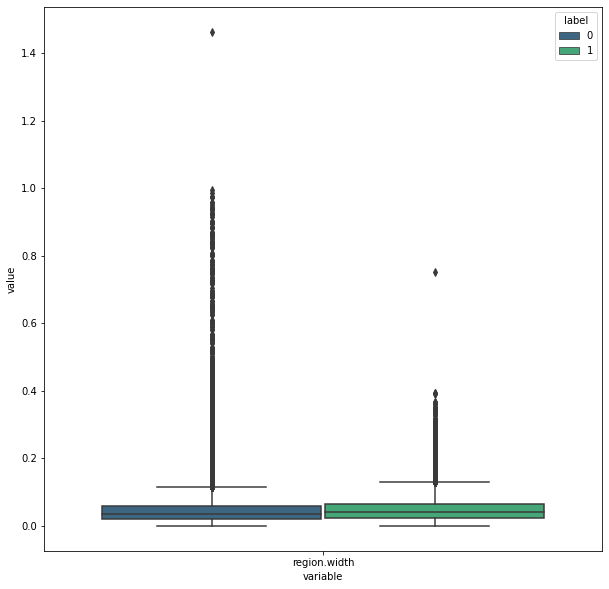

In [112]:
sns.boxplot(x="variable", y="value", hue='label', palette="viridis",
                data=pd.melt(sub_train[["region.width", "label"]], id_vars=["label"]))

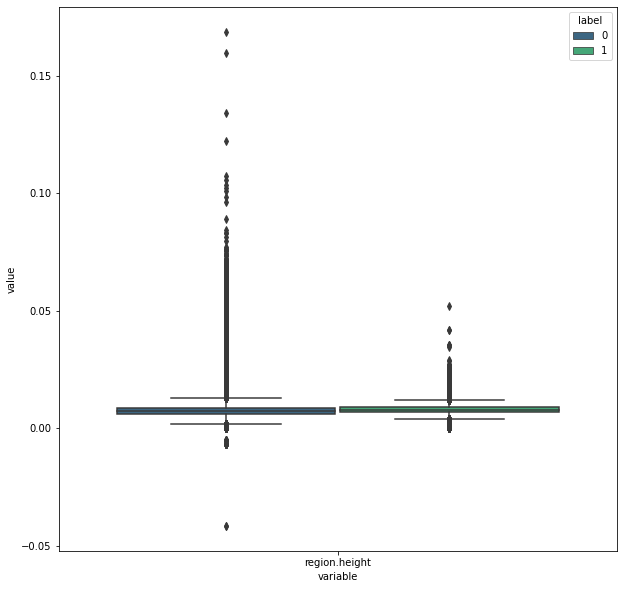

In [113]:
sns.boxplot(x="variable", y="value", hue='label', palette="viridis",
                data=pd.melt(sub_train[["region.height", "label"]], id_vars=["label"]))

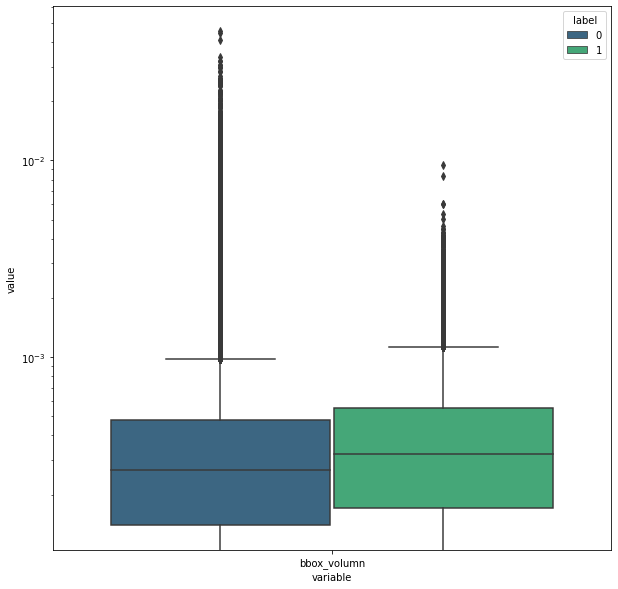

In [114]:
g = sns.boxplot(x="variable", y="value", hue='label', palette="viridis",
                data=pd.melt(sub_train[["bbox_volumn", "label"]], id_vars=["label"]))
g.set_yscale("log")

The boxplots don't look very promising. The non items overlap the classified items in all relevant features. But let's have a look how trees will perform.

### Baseline

Basically, I want to train a tree with depth one, just to see, how good it will perform.

In [115]:
model_columns = [col for col in train.columns if col != "label"]

In [116]:
X_train = train[model_columns]
y_train = train["label"] 

X_test = test[model_columns]
y_test = test["label"] 

In [117]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25)

In [118]:
X_train_sub = sub_train[model_columns]
y_train_sub = sub_train["label"] 

In [119]:
tree = DecisionTreeClassifier(max_depth=1)
tree.fit(X_train_sub, y_train_sub)

DecisionTreeClassifier(max_depth=1)

In [120]:
feature_names = [i for i in X_train_sub.columns]

y_train_str = y_train_sub.astype('str')
y_train_str[y_train_str == '0'] = 'no_text_item'
y_train_str[y_train_str == '1'] = 'text_item'

In [121]:
export_graphviz(tree, out_file='min_tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

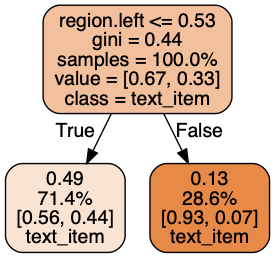

In [122]:
from subprocess import call
call(['dot', '-Tpng', 'min_tree.dot', '-o', 'min_tree.png', '-Gdpi=100'])

from IPython.display import Image
Image(filename = 'min_tree.png')

In [123]:
y_hat = [1 if i <= 0.53 else 0 for i in X_train['region.left']]

In [124]:
pd.DataFrame(confusion_matrix(y_train, y_hat).T, columns=["act_no_text_item","act_text_item"], 
             index=["pred_no_text_item","pred_text_item"])

,act_no_text_item,act_text_item
pred_no_text_item,1335421,13594
pred_text_item,1986431,202906


In [125]:
f1_score(y_train, y_hat)

0.1686780941518482

In [126]:
precision_score(y_train, y_hat)

0.09267919922789411

In [127]:
recall_score(y_train, y_hat)

0.9372101616628176

With one feature, we get to a F1-Score of 0.17, which is really bad. The precision is too low. Too many non-text items are classified as text-items. Let's see, if a more sophisticated approach will help or if the data is too noisy.

In [128]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])


def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

In [129]:
def plot_xgboost_loss(results):
    
    epochs = len(results['validation_0']['logloss'])

    x_axis = range(0, epochs)

    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='val')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    
    
def plot_xgboost_pr_auc(results):
    
    epochs = len(results['validation_0']['logloss'])

    x_axis = range(0, epochs)

    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['aucpr'], label='train')
    ax.plot(x_axis, results['validation_1']['aucpr'], label='val')
    ax.legend()
    plt.ylabel('Precision-Recall AUC')
    plt.title('XGBoost PR-AUC')


## DecisionTree

Training of a slighty bigger decision tree. The F1-score on the undersampled train data looks okayish. Still not great, but it is an improvement.

In [130]:
tree = DecisionTreeClassifier(random_state=0, max_depth=8, criterion='gini')

training_score = cross_val_score(tree, X_train_sub, y_train_sub, cv=5, scoring='f1')
print(f"Decision Tree has a cross_validationg F1 score of {training_score.mean():.2}")

Decision Tree has a cross_validationg F1 score of 0.7


In [131]:
training_score

array([0.69962203, 0.69951066, 0.70472993, 0.68928234, 0.71022981])

In [132]:
tree = DecisionTreeClassifier(random_state=0, max_depth=8, criterion='gini')
tree.fit(X_train_sub, y_train_sub)

DecisionTreeClassifier(max_depth=8, random_state=0)

In [133]:
export_graphviz(tree, out_file='tree_depth_8.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree_depth_8.dot', '-o', 'tree_depth_8.png', '-Gdpi=100'])

0

Let's see, how well the tree generalizes on the whole dataset. The F1-scores drops as expected, since we add only non-text items here. So a decision tree is not the best option, but at least a start.

In [134]:
y_hat = tree.predict(X_val)

In [135]:
pd.DataFrame(confusion_matrix(y_val, y_hat).T, columns=["no_text_item","text_item"], index=["no_text_item","text_item"])

,no_text_item,text_item
no_text_item,929603,20955
text_item,177681,51212


In [136]:
f1_score(y_val, y_hat)

0.34021125357071685

In [137]:
precision_score(y_val, y_hat)

0.2237377289825377

In [138]:
recall_score(y_val, y_hat)

0.7096318261809414

In [139]:
y_hat = tree.predict(X_train)

In [140]:
pd.DataFrame(confusion_matrix(y_train, y_hat).T, columns=["no_text_item","text_item"], index=["no_text_item","text_item"])

,no_text_item,text_item
no_text_item,2789832,63043
text_item,532020,153457


In [141]:
f1_score(y_train, y_hat)

0.3402680999626376

In [142]:
precision_score(y_train, y_hat)

0.22386892630970842

In [143]:
recall_score(y_train, y_hat)

0.7088083140877598

### XGBoost

The imrpovement with the decision tree looks interesting. I would try to train an XGBoost model and see how weel he generalizes. Out of time reasons, I choose more a stomp like approach with a max depth of 2. Since boosing is basicallt gradually learning, this is okay. Probably the number of trees could be better. Also there is much more space for improvement, but any hyperparameter tuning doesn't make sense, as long as the metrics are really bad.

In [144]:
xgb_clf = xgb.XGBClassifier(max_depth=2, n_estimators=200, objective='binary:logistic', gamma=0.1, random_state=1234, early_stopping_rounds=10)\

In [145]:
folds = StratifiedKFold(n_splits = 3, shuffle = True)

estimators = []
# results = np.zeros(len(X))
score = []

for train_index, val_index in folds.split(X_train_sub, y_train_sub):
    sub_X_train, sub_X_val = X_train_sub.iloc[train_index,:], X_train_sub.iloc[val_index,:]

    sub_y_train, sub_y_val = y_train_sub.iloc[train_index].values.ravel(), y_train_sub.iloc[val_index].values.ravel()
    xgb_clf.fit(sub_X_train, sub_y_train)

    estimators.append(xgb_clf)
    results = xgb_clf.predict(sub_X_val)
    score.append(f1_score(sub_y_val, results))

In [146]:
score

[0.7293392409940281, 0.7291122489791284, 0.7289488276299112]

In [147]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_train_sub, y_train_sub, stratify=y_train_sub, test_size=0.25)

In [148]:
eval_set = [(X_train_sub, y_train_sub), (X_val_sub, y_val_sub)]

In [149]:
xgb_clf = xgb.XGBClassifier(eta=0.3,
                            max_depth=2, n_estimators=200, 
                            objective='binary:logistic', 
                            random_state=1234, 
                            early_stopping_rounds=10)

In [150]:
xgb_clf.fit(X_train_sub, y_train_sub, 
            eval_metric=["logloss", "aucpr"],
            eval_set=eval_set,
            verbose=True)

[0]	validation_0-logloss:0.662473	validation_0-aucpr:0.499756	validation_1-logloss:0.664959	validation_1-aucpr:0.499919
[1]	validation_0-logloss:0.640475	validation_0-aucpr:0.506716	validation_1-logloss:0.641214	validation_1-aucpr:0.507137
[2]	validation_0-logloss:0.621047	validation_0-aucpr:0.508785	validation_1-logloss:0.621828	validation_1-aucpr:0.509299
[3]	validation_0-logloss:0.603894	validation_0-aucpr:0.580307	validation_1-logloss:0.60444	validation_1-aucpr:0.579828
[4]	validation_0-logloss:0.590393	validation_0-aucpr:0.588563	validation_1-logloss:0.59037	validation_1-aucpr:0.587271
[5]	validation_0-logloss:0.577072	validation_0-aucpr:0.593311	validation_1-logloss:0.576491	validation_1-aucpr:0.592256
[6]	validation_0-logloss:0.565248	validation_0-aucpr:0.593786	validation_1-logloss:0.565643	validation_1-aucpr:0.592739
[7]	validation_0-logloss:0.55013	validation_0-aucpr:0.622428	validation_1-logloss:0.550555	validation_1-aucpr:0.621149
[8]	validation_0-logloss:0.541501	validatio

[69]	validation_0-logloss:0.405619	validation_0-aucpr:0.731556	validation_1-logloss:0.405351	validation_1-aucpr:0.73427
[70]	validation_0-logloss:0.405092	validation_0-aucpr:0.732288	validation_1-logloss:0.404703	validation_1-aucpr:0.735279
[71]	validation_0-logloss:0.404396	validation_0-aucpr:0.73165	validation_1-logloss:0.404052	validation_1-aucpr:0.734757
[72]	validation_0-logloss:0.404032	validation_0-aucpr:0.73206	validation_1-logloss:0.403716	validation_1-aucpr:0.735195
[73]	validation_0-logloss:0.403785	validation_0-aucpr:0.73217	validation_1-logloss:0.403363	validation_1-aucpr:0.735262
[74]	validation_0-logloss:0.403092	validation_0-aucpr:0.732319	validation_1-logloss:0.402748	validation_1-aucpr:0.73539
[75]	validation_0-logloss:0.402652	validation_0-aucpr:0.733608	validation_1-logloss:0.402261	validation_1-aucpr:0.736861
[76]	validation_0-logloss:0.402395	validation_0-aucpr:0.733977	validation_1-logloss:0.401894	validation_1-aucpr:0.73723
[77]	validation_0-logloss:0.401849	val

[137]	validation_0-logloss:0.387749	validation_0-aucpr:0.750151	validation_1-logloss:0.387005	validation_1-aucpr:0.75423
[138]	validation_0-logloss:0.387657	validation_0-aucpr:0.750168	validation_1-logloss:0.386913	validation_1-aucpr:0.754246
[139]	validation_0-logloss:0.387563	validation_0-aucpr:0.75026	validation_1-logloss:0.386806	validation_1-aucpr:0.754365
[140]	validation_0-logloss:0.387486	validation_0-aucpr:0.750382	validation_1-logloss:0.386715	validation_1-aucpr:0.754498
[141]	validation_0-logloss:0.387378	validation_0-aucpr:0.750588	validation_1-logloss:0.386619	validation_1-aucpr:0.754619
[142]	validation_0-logloss:0.387279	validation_0-aucpr:0.750717	validation_1-logloss:0.386538	validation_1-aucpr:0.754711
[143]	validation_0-logloss:0.387088	validation_0-aucpr:0.750961	validation_1-logloss:0.38633	validation_1-aucpr:0.755009
[144]	validation_0-logloss:0.386925	validation_0-aucpr:0.751163	validation_1-logloss:0.386159	validation_1-aucpr:0.755228
[145]	validation_0-logloss:

XGBClassifier(early_stopping_rounds=10, eta=0.3, max_depth=2, n_estimators=200,
              random_state=1234)

In [151]:
results = xgb_clf.evals_result()

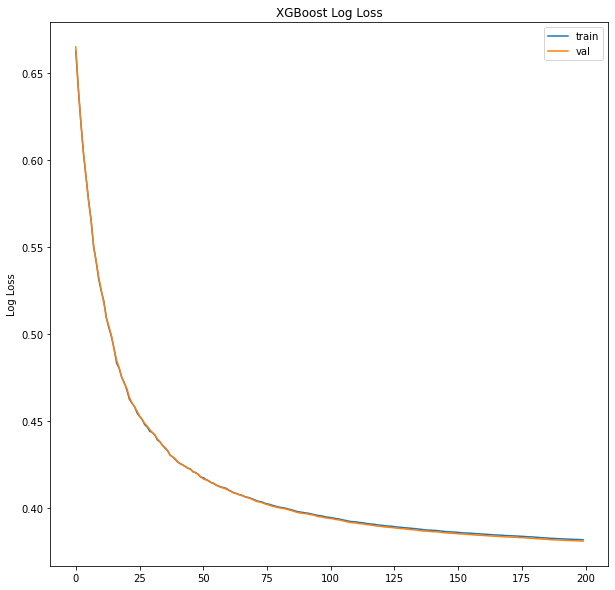

In [152]:
plot_xgboost_loss(results)

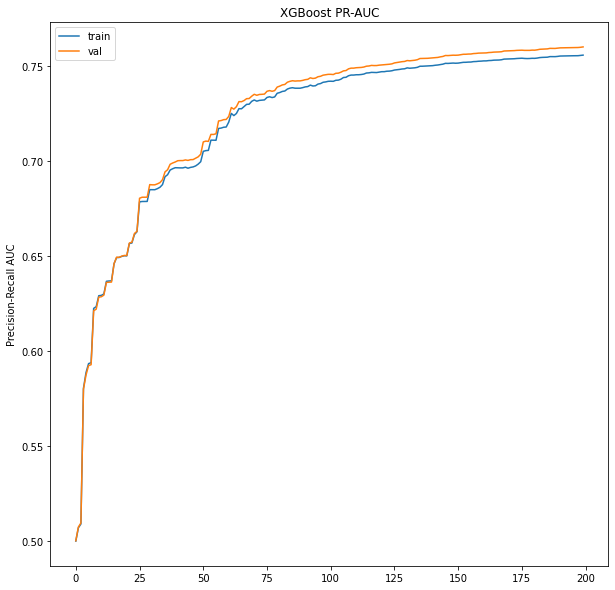

In [153]:
plot_xgboost_pr_auc(results)

In [154]:
y_scores = xgb_clf.predict_proba(X_train_sub)

In [155]:
precisions, recalls, thresholds = precision_recall_curve(y_train_sub, y_scores[:,1])

Here I calculated on the cv training the decision threshold vs precision and recall. The precision curve is a bit bumpy and slowly changes, while the recall reacts stronger to the threshold. Since I'm interested in a better precision (the model lacks here), I go for a decision threshold of 0.6.

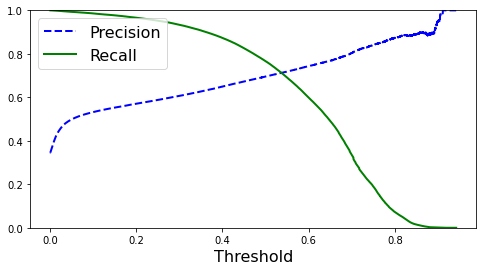

In [156]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [157]:
auc_score = auc(recalls, precisions)
print('XGBoost PR AUC: %.3f' % auc_score)

XGBoost PR AUC: 0.756


Precision vs recall is really low. On the sub-samled data it reaches not more than 0.8. But also, it doesnt fall very much with an increased recall.

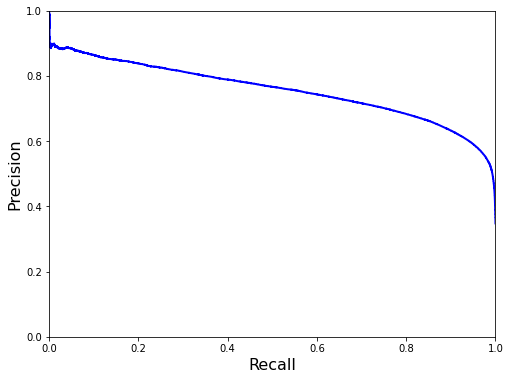

In [158]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

The model is not really good on the under-sampled data. I will apply it to the full training dataset (show more non-texxt items to it) and have a look at the test set.

In [159]:
y_hat_prob = xgb_clf.predict_proba(X_val)

y_hat = [0 if i <= 0.6 else 1 for i in y_hat_prob[:,1]]

In [160]:
pd.DataFrame(confusion_matrix(y_val, y_hat).T, columns=["no_text_item","text_item"], index=["no_text_item","text_item"])

,no_text_item,text_item
no_text_item,992648,28702
text_item,114636,43465


In [161]:
f1_score(y_val, y_hat)

0.3775166327930932

In [162]:
precision_score(y_val, y_hat)

0.27491919722202895

In [163]:
recall_score(y_val, y_hat)

0.6022835922235925

### whole dataset

In [164]:
y_hat_prob = xgb_clf.predict_proba(X_train)

y_hat = [0 if i <= 0.6 else 1 for i in y_hat_prob[:,1]]

In [165]:
pd.DataFrame(confusion_matrix(y_train, y_hat).T, columns=["no_text_item","text_item"], index=["no_text_item","text_item"])

,no_text_item,text_item
no_text_item,2978918,86690
text_item,342934,129810


In [166]:
f1_score(y_train, y_hat)

0.37667357278409386

In [167]:
precision_score(y_train, y_hat)

0.2745883607195438

In [168]:
recall_score(y_train, y_hat)

0.5995842956120092

In [169]:
precisions, recalls, _ = precision_recall_curve(y_train, y_hat_prob[:,1])
auc(recalls, precisions)

0.30932480365379555

### Test dataset

In [170]:
y_hat_prob = xgb_clf.predict_proba(X_test)

y_hat = [0 if i <= 0.6 else 1 for i in y_hat_prob[:,1]]

In [171]:
pd.DataFrame(confusion_matrix(y_test, y_hat).T, columns=["no_text_item","text_item"], index=["no_text_item","text_item"])

,no_text_item,text_item
no_text_item,172915,3923
text_item,24350,6151


In [172]:
f1_score(y_test, y_hat)

0.3031916204559458

In [173]:
precision_score(y_test, y_hat)

0.20166551916330613

In [174]:
recall_score(y_test, y_hat)

0.610581695453643

In [175]:
precisions, recalls, _ = precision_recall_curve(y_test, y_hat_prob[:,1])
auc(recalls, precisions)

0.21765784521150594

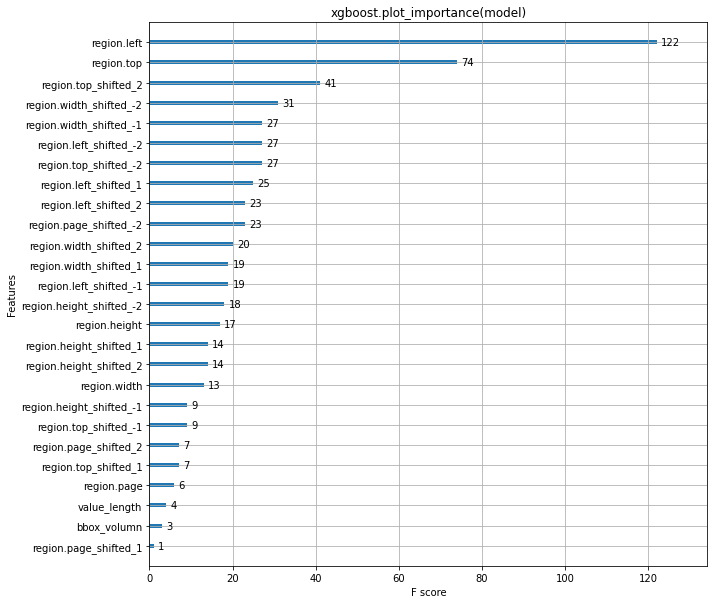

In [176]:
xgb.plot_importance(xgb_clf)
plt.title("xgboost.plot_importance(model)")
plt.show()

## Sequential classification

The idea of an LSTM or RNN seems possible, since the structure follows a sequence. I havn't applied LSTMs/RNNs in a long run, so this is a very first prototype.

In [34]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [35]:
def add_lstm_sequence(data: pd.DataFrame) -> pd.DataFrame:
    
    colnames = ['region.left', 'region.top', 'region.width', 'region.height', 'region.page']
    
    base = data.copy()
    
    for i in range(-10,10):
        if i == 0:
            continue
    
        shift_data = base.groupby(['id'])['region.left', 'region.top', 'region.width', 'region.height', 'region.page'].shift(i)
        new_col = [col + f"_shifted_{i}" for col in colnames]

        shift_data.columns = new_col

        if i < 0:
            data = pd.concat([shift_data, data], axis=1)
        else:
            data = pd.concat([data, shift_data], axis=1)

    
    del [base, shift_data]

    return data

In [36]:
def lstm_feature_engineering(data):
    
    feature_engineering_strategy = [
                                    add_lstm_sequence,
                                    fill_nan,
                                    drop_unrelated_columns
                                    ]

    feature_creator = Transformer(feature_engineering_strategy)
    data = feature_creator.fit_transform(data)
    
    return data

In [37]:
def drop_unrelated_columns(data: pd.DataFrame) -> pd.DataFrame:
    return data.drop(["value", "id", "indices"], axis=1)

In [38]:
train = pd.read_csv("hypatos-ds-train.csv")
test = pd.read_csv("hypatos-ds-test.csv")

In [39]:
train = preprocessing(train, True)
test = preprocessing(test)

In [40]:
train.groupby(['id']).size().describe()

count    24073.000000
mean       195.979022
std        113.535822
min         15.000000
25%        130.000000
50%        174.000000
75%        231.000000
max       1725.000000
dtype: float64

In [41]:
train = lstm_feature_engineering(train)
test = lstm_feature_engineering(test)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


In [42]:
model_columns = [i for i in train.columns if i != 'label']

In [43]:
X_train = train[model_columns]
y_train = train["label"] 

X_test = test[model_columns]
y_test = test["label"] 

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25)

In [45]:
neg, pos = sum(y_train==0), sum(y_train==1)
total = neg + pos

This build a Sequence of the bounding boxes. I look at the bounding box before and behind the specific bounding box. So I create a sequence of 3 bboxes for the LSTM. 

In [46]:
scaler = MinMaxScaler(feature_range = (0, 1))
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

for simplicity remove value_lengths and bbox volumne, since both are not part of the sequencing

In [47]:
X_train.shape

(3538352, 100)

Stacking in a shape of [batch_size, sequence_length, n_features]

In [48]:
X_train = X_train.reshape((X_train.shape[0], 20, 5))
X_val = X_val.reshape((X_val.shape[0], 20, 5))
X_test = X_test.reshape((X_test.shape[0], 20, 5))

# X_train = X_train.reshape((X_train.shape[0], 1, (X_train.shape[1])))
# X_val = X_val.reshape((X_val.shape[0], 1, (X_val.shape[1])))
# X_test = X_test.reshape((X_test.shape[0], 1, (X_test.shape[1])))


print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

Training features shape: (3538352, 20, 5)
Validation features shape: (1179451, 20, 5)
Test features shape: (207339, 20, 5)


Adding weights for the model. Positive labels get a heigher weight, which afaik will be multiplied with the gradient in the cost function.

In [49]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.53
Weight for class 1: 8.17


In [50]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

In [51]:
def make_model(metrics = METRICS):
    
    model = Sequential()
    model.add(LSTM(42, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(42))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer= "adam", metrics=metrics)  

    return model

In [52]:
early_stopping = EarlyStopping(
    monitor='val_binary_crossentropy', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

The training takes too long; probably I should have taken only one LSTM layer and less units. Dropout layers are introduced to prevent overfitting. From my prototyping I can conclude, that the class weights improve the learning a lot. Most of my previous approaches failed, because the model was only predicting zeros.

In [53]:
weighted_model = make_model()

weighted_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20, 42)            8064      
_________________________________________________________________
lstm_4 (LSTM)                (None, 42)                14280     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 43        
Total params: 22,387
Trainable params: 22,387
Non-trainable params: 0
_________________________________________________________________


In [54]:
weighted_history = weighted_model.fit(
    X_train,
    y_train.values,
    batch_size=128,
    epochs=10,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val.values),
    class_weight=class_weight,
    verbose=1)

Train on 3538352 samples, validate on 1179451 samples
Epoch 1/10
3538352/3538352 [==============================] - 1000s 283us/step - loss: 0.4559 - tp: 182075.0000 - fp: 950137.0000 - tn: 2371715.0000 - fn: 34425.0000 - accuracy: 0.7217 - precision: 0.1608 - recall: 0.8410 - auc: 0.8600 - val_loss: 0.4385 - val_tp: 64432.0000 - val_fp: 253984.0000 - val_tn: 853300.0000 - val_fn: 7735.0000 - val_accuracy: 0.7781 - val_precision: 0.2024 - val_recall: 0.8928 - val_auc: 0.9053
Epoch 2/10


/usr/local/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_binary_crossentropy` which is not available. Available metrics are: val_loss,val_tp,val_fp,val_tn,val_fn,val_accuracy,val_precision,val_recall,val_auc,loss,tp,fp,tn,fn,accuracy,precision,recall,auc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


3538352/3538352 [==============================] - 1066s 301us/step - loss: 0.3560 - tp: 192781.0000 - fp: 667598.0000 - tn: 2654254.0000 - fn: 23719.0000 - accuracy: 0.8046 - precision: 0.2241 - recall: 0.8904 - auc: 0.9173 - val_loss: 0.3655 - val_tp: 64717.0000 - val_fp: 214879.0000 - val_tn: 892405.0000 - val_fn: 7450.0000 - val_accuracy: 0.8115 - val_precision: 0.2315 - val_recall: 0.8968 - val_auc: 0.9234
Epoch 3/10
3538352/3538352 [==============================] - 982s 277us/step - loss: 0.3277 - tp: 195221.0000 - fp: 606293.0000 - tn: 2715559.0000 - fn: 21279.0000 - accuracy: 0.8226 - precision: 0.2436 - recall: 0.9017 - auc: 0.9301 - val_loss: 0.3361 - val_tp: 64907.0000 - val_fp: 188550.0000 - val_tn: 918734.0000 - val_fn: 7260.0000 - val_accuracy: 0.8340 - val_precision: 0.2561 - val_recall: 0.8994 - val_auc: 0.9335
Epoch 4/10
3538352/3538352 [==============================] - 991s 280us/step - loss: 0.3117 - tp: 196304.0000 - fp: 572818.0000 - tn: 2749034.0000 - fn: 20196.

The model performs worse than the xgboost model; Interestingly in one of my prototypes, I achieved an F1-Score of 0.34 with a mugh higher precision. No idea, what went wrong, when I transformed the model to this notebook. 

The train-validation curves won't show any overfitting. The precision is still quite bad. The model predicts too many False Positives. Also the model took too long for training. One LSTM layer less and probably a few nodes less would have been better. 

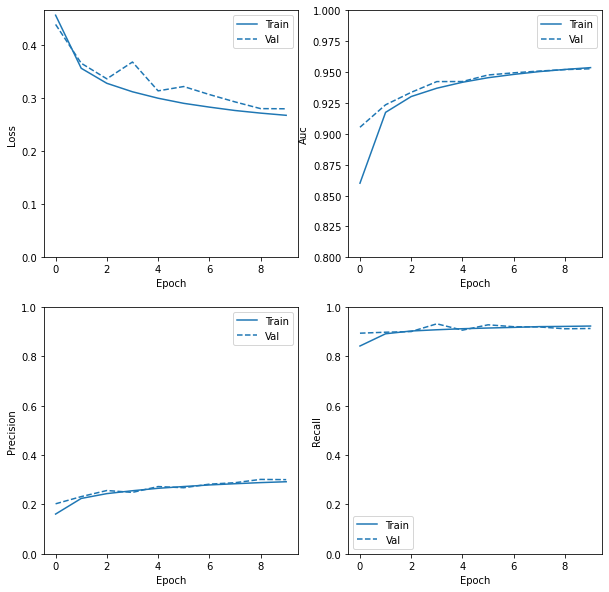

In [55]:
plot_metrics(weighted_history)

In [56]:
y_hat_prob = weighted_model.predict(X_train, batch_size=256)

In [57]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_hat_prob)

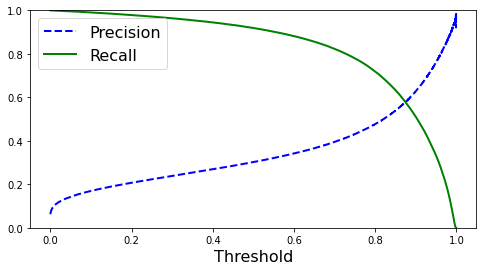

In [60]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [61]:
auc_score = auc(recalls, precisions)
print('XGBoost PR AUC: %.3f' % auc_score)

XGBoost PR AUC: 0.624


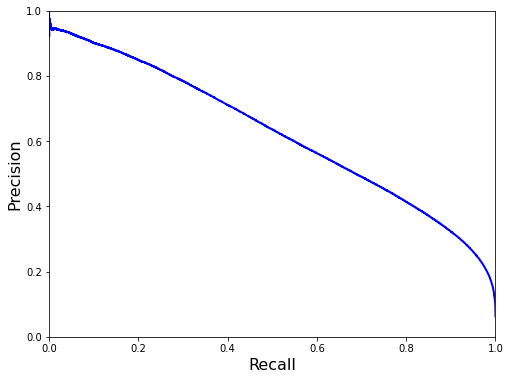

In [62]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [63]:
y_hat = weighted_model.predict_classes(X_test, batch_size=128, verbose=0)

In [64]:
pd.DataFrame(confusion_matrix(y_test, y_hat).T, columns=["no_text_item","text_item"], index=["no_text_item","text_item"])

,no_text_item,text_item
no_text_item,167201,1257
text_item,30064,8817


In [65]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=256, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)


loss :  0.3046565614066303
tp :  8817.0
fp :  30064.0
tn :  167201.0
fn :  1257.0
accuracy :  0.8489382266998291
precision :  0.2267688661813736
recall :  0.8752233386039734
auc :  0.938652753829956


In [66]:
y_hat_prob = weighted_model.predict(X_test, batch_size=256)

Based on the trashold curve, I would pick 0.85.

In [76]:
threshold = 0.85

In [77]:
f1_score(y_test, y_hat_prob>threshold)

0.5269371393330691

In [70]:
precision_score(y_test, y_hat_prob>threshold)

0.4736675378157916

In [71]:
recall_score(y_test, y_hat_prob>threshold)

0.5937065713718483

In [72]:
y_hat_th = [1 if i > threshold else 0 for i in y_hat_prob]

In [73]:
pd.DataFrame(confusion_matrix(y_test, y_hat_th).T, columns=["no_text_item","text_item"], index=["no_text_item","text_item"])

,no_text_item,text_item
no_text_item,190619,4093
text_item,6646,5981
